In [1]:
# 📌 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [5]:
# 📌 2. Load Urdu Dataset
df = pd.read_excel("/content/drive/MyDrive/DL-Models/Urdu Corpus.xlsx")
df.columns = df.columns.str.strip()
print(df.head())
urdu_sentences = df['Text Lines'].dropna().astype(str).tolist()

def clean_text(text):
    return text.replace("ي", "ی").replace("ك", "ک").strip()

urdu_sentences = [clean_text(s) for s in urdu_sentences if len(s.split()) >= 3]
print("Total Sentences:", len(urdu_sentences))


                                          Text Lines
0  حنفی، حافظ محمد زائد حجازی، حاجی محمد جمیل، ڈا...
1  پر بھی توجہ دیتے۔ جن مبارک ساعتوں میں عبادات ک...
2  اس وقت عالم اسلا م دو اہم سنگین مسئلوں سے دوچا...
3  اس سے قبل اتوار کو جب کھیل شروع ہوا تو جنوبی ا...
4  کی ہے کہ جنرل راحیل شریف کو ملک اور پاکستان کے...
Total Sentences: 17779


In [6]:
# 📌 3. Tokenization and Sequences
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(urdu_sentences)
vocab_size = len(tokenizer.word_index) + 1

MAX_SEQ_LEN = 40
input_sequences = []
for sentence in urdu_sentences:
    token_list = tokenizer.texts_to_sequences([sentence])[0]
    for i in range(1, len(token_list)):
        ngram_seq = token_list[:i+1]
        if len(ngram_seq) <= MAX_SEQ_LEN:
            input_sequences.append(ngram_seq)

input_sequences = pad_sequences(input_sequences, maxlen=MAX_SEQ_LEN, padding='pre')
X = input_sequences[:, :-1]
y = input_sequences[:, -1]

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 📌 Define Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5, verbose=1)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=100),
    Dropout(0.4),
    GRU(100, kernel_regularizer=l2(0.001)),
    Dropout(0.4),
    Dense(vocab_size, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0005),
    metrics=['accuracy']
)


# 📌 Build and Show Summary
model.build(input_shape=(None, MAX_SEQ_LEN - 1))
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 39, 100)        │     2,180,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 39, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 100)            │        60,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 21800)          │     2,201,800 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,442,400 (16.95 MB)

 Trainable params: 4,442,400 (16.95 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# 📌 6. Train Model
history = model.fit(
    X, y,
    epochs=30,
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stop, lr_reduce],
    verbose=1
)

Epoch 1/30
2552/2552 ━━━━━━━━━━━━━━━━━━━━ 33s 11ms/step - accuracy: 0.0334 - loss: 7.8435 - val_accuracy: 0.0360 - val_loss: 7.3810 - learning_rate: 5.0000e-04
Epoch 2/30
2552/2552 ━━━━━━━━━━━━━━━━━━━━ 30s 12ms/step - accuracy: 0.0418 - loss: 7.2267 - val_accuracy: 0.0474 - val_loss: 7.3047 - learning_rate: 5.0000e-04
Epoch 3/30
2552/2552 ━━━━━━━━━━━━━━━━━━━━ 40s 11ms/step - accuracy: 0.0535 - loss: 7.0332 - val_accuracy: 0.0595 - val_loss: 7.2259 - learning_rate: 5.0000e-04
Epoch 4/30
2552/2552 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - accuracy: 0.0643 - loss: 6.8725 - val_accuracy: 0.0701 - val_loss: 7.2091 - learning_rate: 5.0000e-04
Epoch 5/30
2552/2552 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - accuracy: 0.0740 - loss: 6.7575 - val_accuracy: 0.0763 - val_loss: 7.1917 - learning_rate: 5.0000e-04
Epoch 6/30
2552/2552 ━━━━━━━━━━━━━━━━━━━━ 29s 11ms/step - accuracy: 0.0819 - loss: 6.6269 - val_accuracy: 0.0826 - val_loss: 7.1656 - learning_rate: 5.0000e-04
Epoch 7/30
2552/2552 ━━━━━━━━━━━━━━━━━━━

In [9]:
# 📌 7. Save Model and Tokenizer
model.save("/content/urdu_GRU_model.keras")
with open("/content/urdu_tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)


In [10]:

# 📌 8. Text Generation Function
def generate_urdu_text(seed_text, next_words=25, temperature=1.0, top_k=5):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=MAX_SEQ_LEN - 1, padding='pre')

        predictions = model.predict(token_list, verbose=0)[0]

        predictions = np.log(predictions + 1e-7) / temperature
        exp_preds = np.exp(predictions)
        predictions = exp_preds / np.sum(exp_preds)

        top_indices = predictions.argsort()[-top_k:][::-1]
        top_probs = predictions[top_indices]
        top_probs /= np.sum(top_probs)

        predicted_index = np.random.choice(top_indices, p=top_probs)
        predicted_word = tokenizer.index_word.get(predicted_index, '')

        if predicted_word in ["<OOV>", ""]:
            break

        seed_text += ' ' + predicted_word

    return seed_text

In [11]:
seed = "پاکستان کی معیشت"
generated_text = generate_urdu_text(seed_text=seed, next_words=25, temperature=0.8, top_k=5)
print("Generated Urdu Text:\n", generated_text)


Generated Urdu Text:
 پاکستان کی معیشت میں کہا کہ وہ ایک سال کے لئے اس سے بھی بھی اس کو میں ہے جو یہ یہ بات تھا کہ وہ اس سے


In [12]:
seed = "زندگی کا اصل حسن سادگی میں ہے"
generated_text = generate_urdu_text(seed_text=seed, next_words=25, temperature=1.2, top_k=10)
print("Generated Urdu Text:\n", generated_text)

Generated Urdu Text:
 زندگی کا اصل حسن سادگی میں ہے اور وہ وہ ایک بار بھی کیا تھا اور اس طرح کی قیمت میں بھی ہے اور وہ اس کے لئے پاکستان میں اپنی بات


In [16]:
test_seeds = [
    "پاکستان میں تعلیم",           # Education in Pakistan
    "خوشی کی اہمیت",              # Importance of happiness
    "زندگی ایک سفر ہے",            # Life is a journey
    "محنت کا پھل",                 # Fruit of hard work
    "نوجوانوں کا مستقبل"           # Future of youth
]

for seed in test_seeds:
    print(f"\nSeed: {seed}")
    print("\nGenerated:", generate_urdu_text(seed_text=seed, next_words=25, temperature=1.2, top_k=20))



Seed: پاکستان میں تعلیم

Generated: پاکستان میں تعلیم سے بھی کر رہے ۔ اس کے درمیان ہی میں نے اس روز حکومت نے یہ ہی ہے۔ کہ اس میں کے ساتھ سے ایک

Seed: خوشی کی اہمیت

Generated: خوشی کی اہمیت کے دل کی ضرورت کے ذریعے اور حکومت کو ایک ایک ٹیکس سے زائد اور پاکستان کا اظہار ہو گیا ہے۔ ہم میں یہ زیادہ

Seed: زندگی ایک سفر ہے

Generated: زندگی ایک سفر ہے ، اگر کہ ہم بھی ہے کہ وہ ان کے بارے میں بھی اپنے نام کو کم کرتے تھے ان کے بعد نے پاکستان پر

Seed: محنت کا پھل

Generated: محنت کا پھل بن گا۔ ان کی ایم کی اس کی زندگی کے مقابلے میں اپنے لیے بھی اس کا شکار ہوتا ہے۔ انہوں نے اپنے ان کو

Seed: نوجوانوں کا مستقبل

Generated: نوجوانوں کا مستقبل سے اپنے ساتھ یہ زیادہ ٹیکس کے لیے میں ہے لیکن پھر اس کے پاس اپنی صحت کو ایک ماہ میں اور ایک ممالک کا


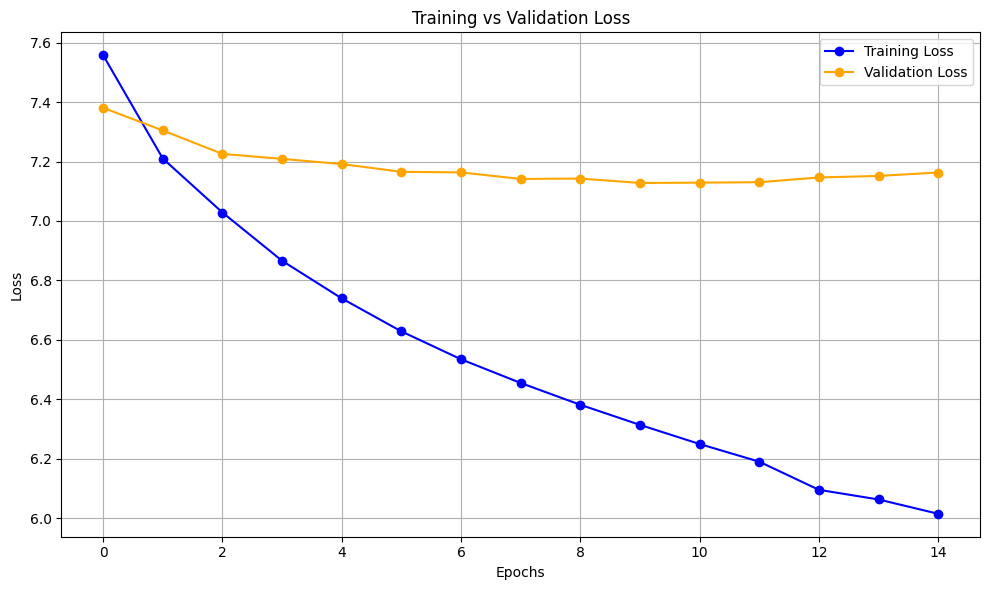

In [17]:
import matplotlib.pyplot as plt

# Plot loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange', marker='o')
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
